# Building a CNN-based architecture using PyTorch

In [23]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import Adam, SGD
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [24]:
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# Defining the dataset
X_train = torch.tensor([[[[1,2,3,4],[2,3,4,5],[5,6,7,8],[1,3,4,5]]],[[[-1,2,3,-4],[2,-3,4,5],[-5,6,-7,8],[-1,-3,-4,-5]]]]).to(device).float()
X_train /= 8
y_train = torch.tensor([0,1]).to(device).float()

In [26]:
# Define our model
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 1, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(1, 1),
        nn.Sigmoid()
    ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [27]:
# !pip install torch_summary # not needed 'cause already installed
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, X_train)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [28]:
help(nn.Conv2d)

Help on class Conv2d in module torch.nn.modules.conv:

class Conv2d(_ConvNd)
 |  Conv2d(in_channels: int, out_channels: int, kernel_size: Union[int, Tuple[int, int]], stride: Union[int, Tuple[int, int]] = 1, padding: Union[str, int, Tuple[int, int]] = 0, dilation: Union[int, Tuple[int, int]] = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros', device=None, dtype=None) -> None
 |  
 |  Applies a 2D convolution over an input signal composed of several input
 |  planes.
 |  
 |  In the simplest case, the output value of the layer with input size
 |  :math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
 |  can be precisely described as:
 |  
 |  .. math::
 |      \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
 |      \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)
 |  
 |  
 |  where :math:`\star` is the valid 2D `cross-correlation`_ operator,
 |  :math:`N

In [29]:
# Training the model
def train_batch(x, y, model, opt, loss_fn):
    # Put it into training mode
    model.train()

    # Pass the input through the model
    prediction = model(x)

    # Calculate the loss
    batch_loss = loss_fn(prediction.squeeze(0), y)
    batch_loss.backward()

    # Step the optimizer and reset it
    optimizer.step()
    optimizer.zero_grad()

    return batch_loss.item()

In [30]:
# Define the dataloader
trn_dl = DataLoader(TensorDataset(X_train, y_train))

# Train the model for 2000 epochs
for epoch in range(2000):
    print(epoch) if epoch % 200 == 0 else None
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        train_batch(x, y, model, optimizer, loss_fn)

0
200
400
600
800
1000
1200
1400
1600
1800


In [31]:
# Do a prediction with the model
model(X_train[:1])

tensor([[0.5332]], grad_fn=<SigmoidBackward0>)

# Image classification with Deep CNNs

In [5]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data_folder = "/l/disk0/ghenrique/Documents/Pytorch_book/code/data"
fmnist = datasets.FashionMNIST(data_folder, download=False, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [6]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1, 1, 28, 28) # We changed this line 
        self.x, self.y = x, y
    
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)
    
    def __len__(self):
        return len(self.x)

from torch.optim import Adam

# Redefine our model
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer


0
1
2
3
4


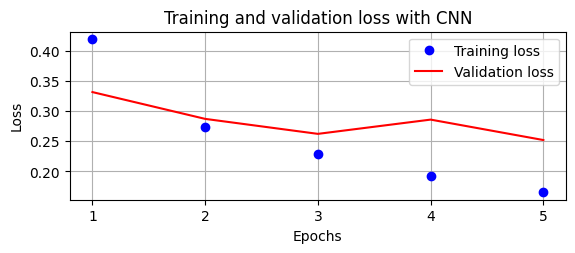

/tmp/ipykernel_6828/543436075.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


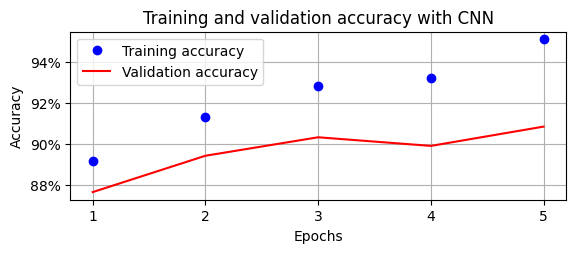

In [7]:
# Now we train the model just like before
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

     

def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl
     

@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()
     

trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

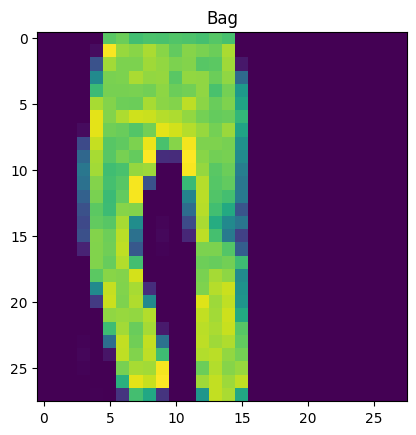

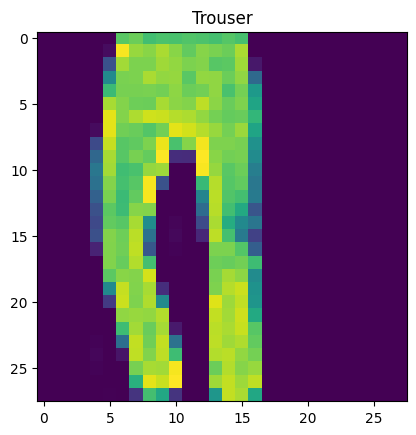

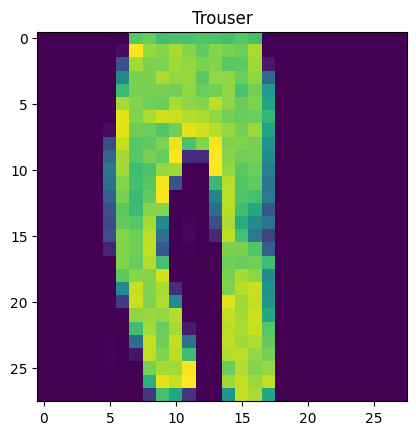

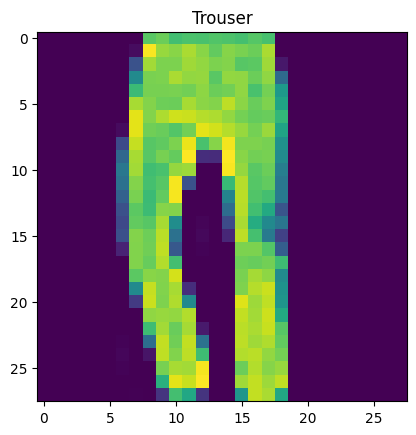

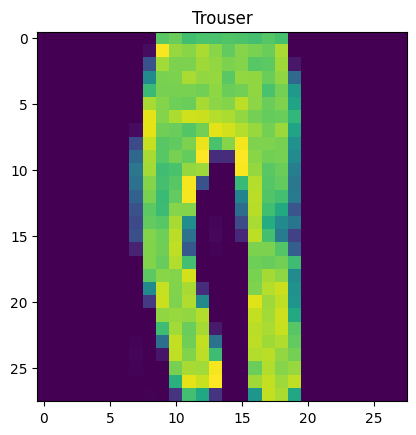

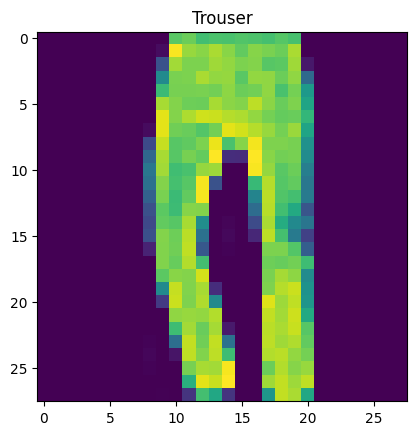

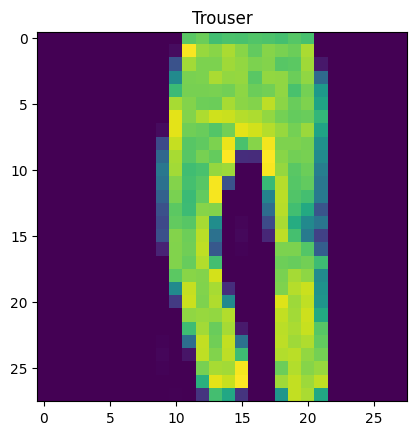

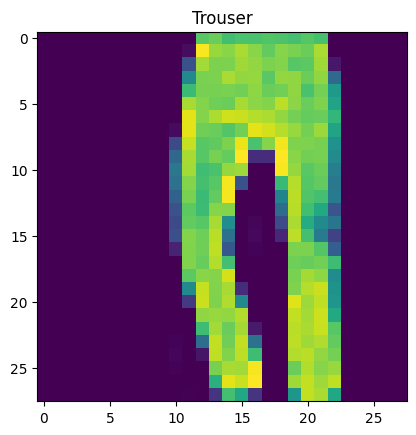

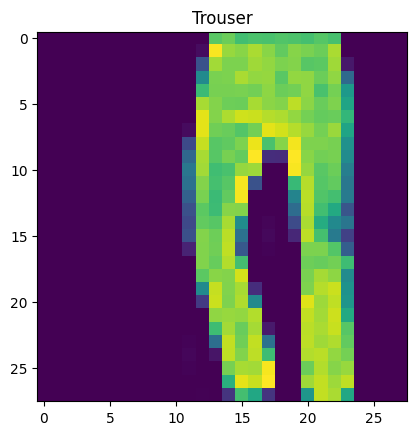

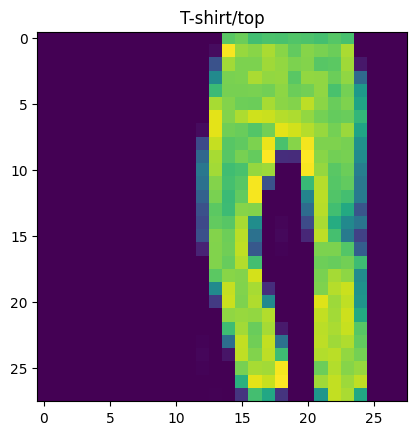

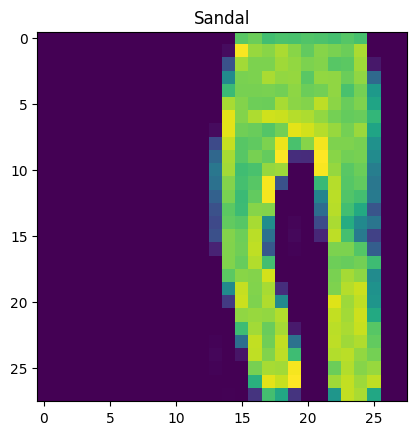

In [8]:
# Now we translate the image 5 pixels to see if the performance changes
preds = []
ix = 24300
for px in range(-5,6):
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  img2 = np.roll(img, px, axis=1)
  img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  pred = np.exp(np_output)/np.sum(np.exp(np_output))
  preds.append(pred)
  plt.imshow(img2)
  plt.title(fmnist.classes[pred[0].argmax()])
  plt.show()

In [9]:
np.array(preds).shape

(11, 1, 10)

<Axes: title={'center': 'Probability of each class for various translations'}>

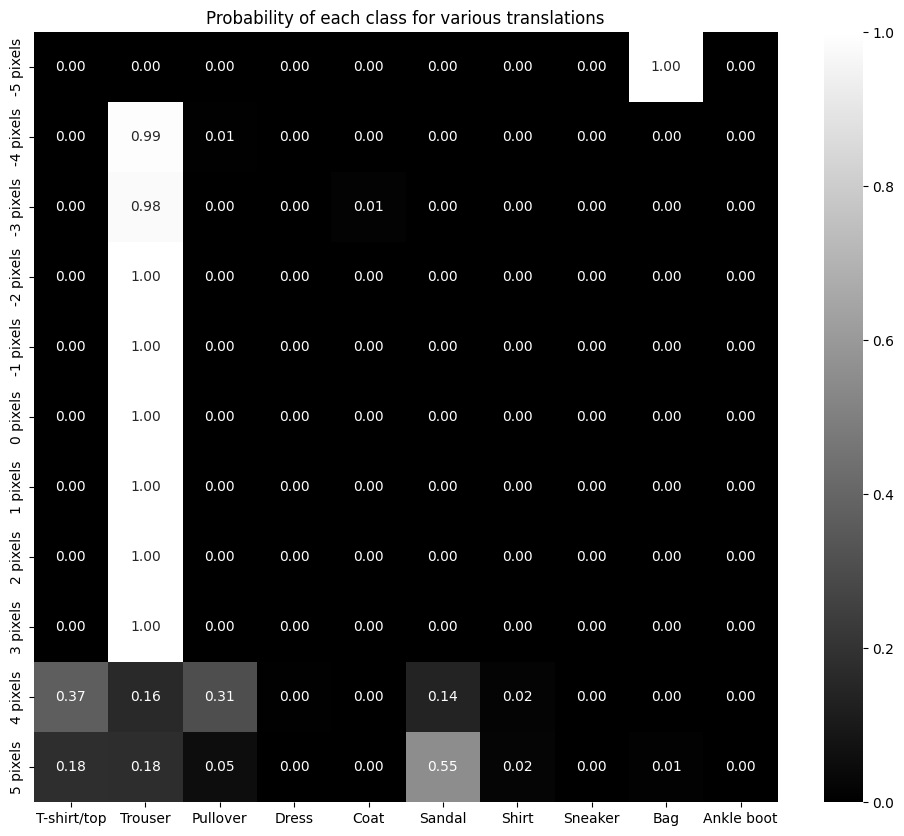

In [10]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for \
various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot=True, \
ax=ax, fmt='.2f', xticklabels=fmnist.classes, \
yticklabels=[str(i)+str(' pixels') \
for i in range(-5,6)], cmap='gray')

# Data Augmentation 

In [20]:
from torchvision import datasets
import torch
data_folder = '/l/disk0/ghenrique/Documents/Pytorch_book/code/data' # This can be any directory you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=False, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

## Translation, Scaling and Shearing

Text(0.5, 1.0, 'Scaled image')

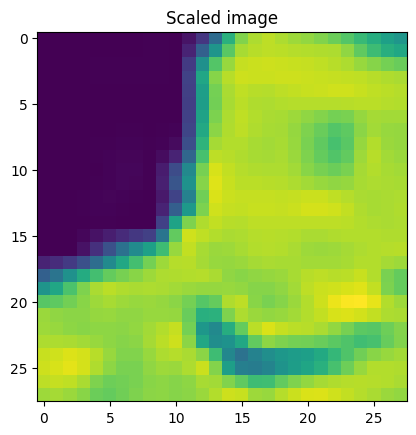

In [22]:
# !pip install imgaug
from imgaug import augmenters as iaa

# Zoom in
aug = iaa.Affine(scale=2)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Scaled image')

Text(0.5, 1.0, 'Translated image by 10 pixels')

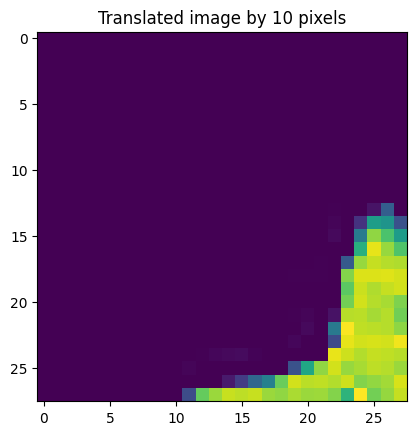

In [23]:
# Translating
aug = iaa.Affine(translate_px=10)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title("Translated image by 10 pixels")

Text(0.5, 1.0, 'Translation of 10 pixels \nacrros columns and 2 pixels over rows')

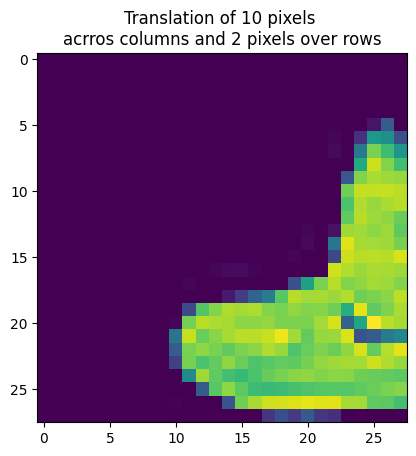

In [25]:
# Translating specifying the amount on the x and y axis
aug = iaa.Affine(translate_px={'x':10, 'y':2})
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Translation of 10 pixels \nacrros columns \
and 2 pixels over rows')

Text(0.5, 1.0, 'Shear of image \nby 30 degrees')

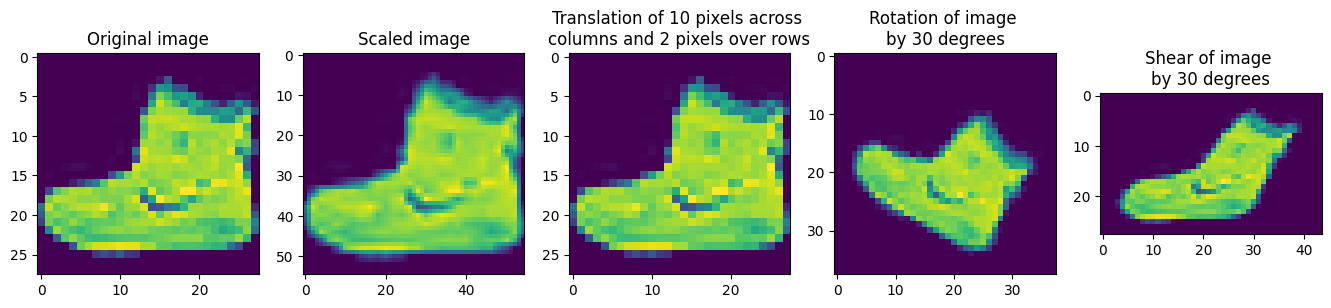

In [26]:
plt.figure(figsize=(20,20))
plt.subplot(161)
plt.imshow(to_numpy(tr_images[0]))
plt.title('Original image')
plt.subplot(162)
aug = iaa.Affine(scale=2, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Scaled image')
plt.subplot(163)
aug = iaa.Affine(translate_px={'x':10,'y':2}, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Translation of 10 pixels across \ncolumns and \
2 pixels over rows')
plt.subplot(164)
aug = iaa.Affine(rotate=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Rotation of image \nby 30 degrees')
plt.subplot(165)
aug = iaa.Affine(shear=30, fit_output=True)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])))
plt.title('Shear of image \nby 30 degrees')

## Rotation

Text(0.5, 1.0, 'Rotation of image by 30 degrees')

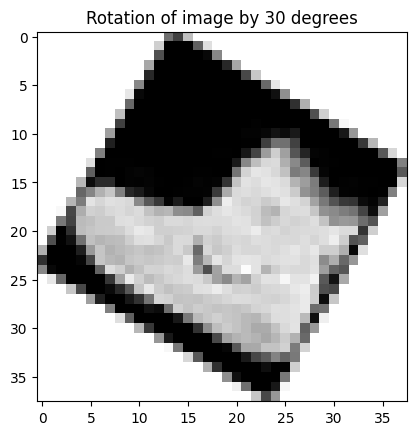

In [31]:
# Changing the cval to 255 (the value that the fit_output is gonna
# put on the missing pixels after the rotation operation)
aug = iaa.Affine(rotate=30, fit_output=True, cval=255)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap="gray")
plt.title('Rotation of image by 30 degrees')

Text(0.5, 1.0, 'Rotation of image by \n30 degrees with wrap mode')

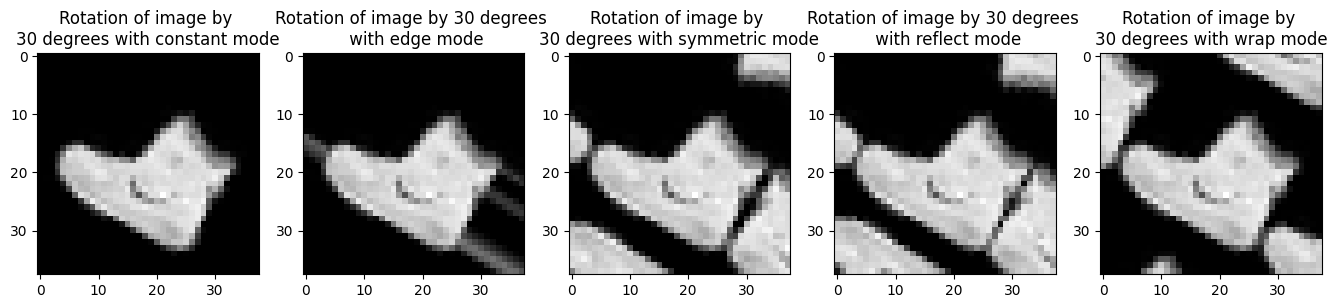

In [32]:
plt.figure(figsize=(20,20))
plt.subplot(161)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with constant mode')
plt.subplot(162)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='edge')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees \n with edge mode')
plt.subplot(163)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='symmetric')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with symmetric mode')
plt.subplot(164)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='reflect')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by 30 degrees \n with reflect mode')
plt.subplot(165)
aug = iaa.Affine(rotate=30, fit_output=True, cval=0, mode='wrap')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.title('Rotation of image by \n30 degrees with wrap mode')

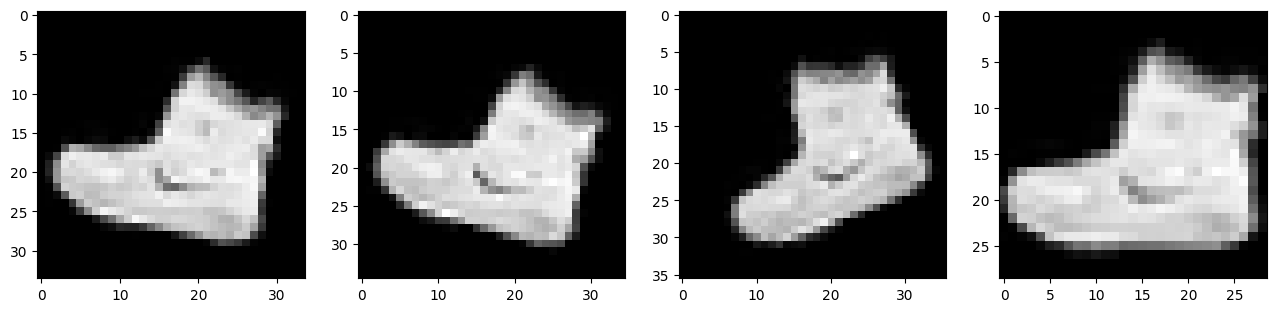

In [42]:
# This is the range (-45, 45) that the images will be rotated by
plt.figure(figsize=(20,20))
plt.subplot(151)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(152)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(153)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')
plt.subplot(154)
aug = iaa.Affine(rotate=(-45,45), fit_output=True, mode='constant')
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray')

## Changing Brightness

Text(0.5, 1.0, 'Pixels multiplied by 0.5')

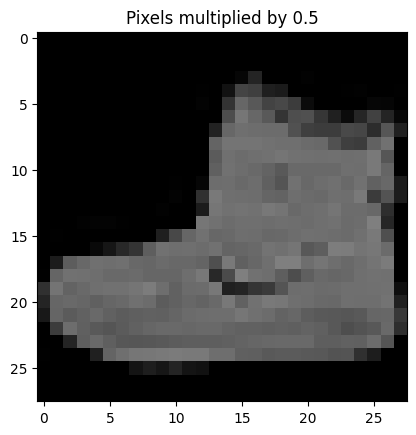

In [48]:

aug = iaa.Multiply(0.5)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray', \
vmin = 0, vmax = 255)
plt.title('Pixels multiplied by 0.5')

Text(0.5, 1.0, 'Pixel contrast by 0.5')

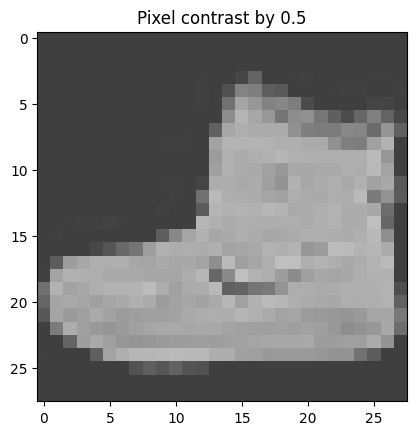

In [49]:
aug = iaa.LinearContrast(0.5)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray', \
           vmin = 0, vmax = 255)
plt.title('Pixel contrast by 0.5')

## Blurring/adding noise

Text(0.5, 1.0, 'Gaussian blurring of image')

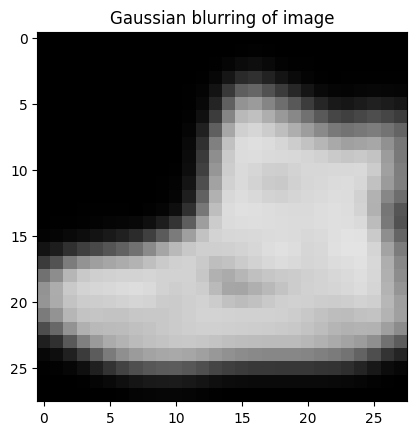

In [50]:
aug = iaa.GaussianBlur(sigma=1)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray', \
vmin = 0, vmax = 255)
plt.title('Gaussian blurring of image')

Text(0.5, 1.0, 'Random 20% salt and pepper noise')

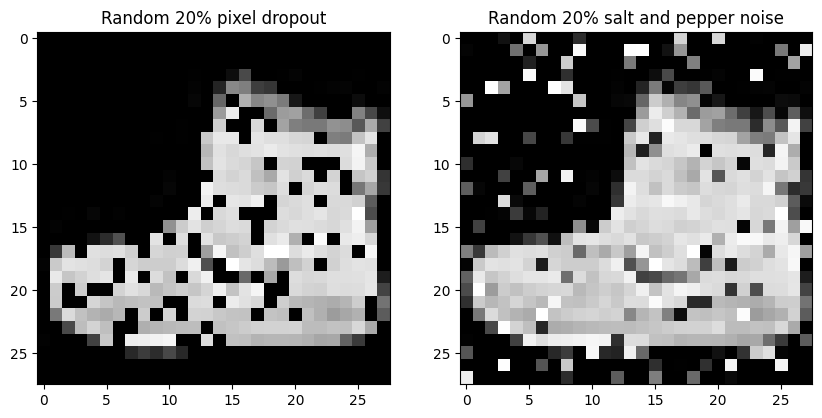

In [51]:
plt.figure(figsize=(10,10))
plt.subplot(121)
aug = iaa.Dropout(p=0.2)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray', \
vmin = 0, vmax = 255)
plt.title('Random 20% pixel dropout')
plt.subplot(122)
aug = iaa.SaltAndPepper(0.2)
plt.imshow(aug.augment_image(to_numpy(tr_images[0])), cmap='gray', \
vmin = 0, vmax = 255)
plt.title('Random 20% salt and pepper noise')

## Doing various augmentations sequentially

In [53]:
seq = iaa.Sequential([
    iaa.Dropout(p=0.2),
    iaa.Affine(rotate=(-30, 30))], random_order=True)

Text(0.5, 1.0, 'Image augmented using a \nrandom order of the two augmentations')

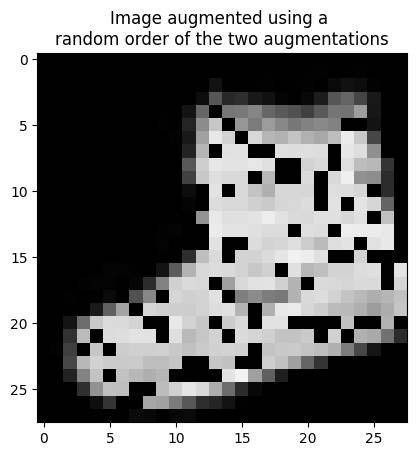

In [56]:
plt.imshow(seq.augment_image(to_numpy(tr_images[0])), cmap='gray', \
vmin = 0, vmax = 255)
plt.title('Image augmented using a \nrandom order \
of the two augmentations')

## Performing data augmentation on a batch of images

### Augmenting 32 images, one at a time 

In [57]:
from torchvision import datasets
import torch
data_folder = '/l/disk0/ghenrique/Documents/Pytorch_book/code/data'
fmnist = datasets.FashionMNIST(data_folder, download=True, \
train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [60]:
from imgaug import augmenters as iaa
aug = iaa.Sequential([
    iaa.Affine(translate_px={'x':(-10, 10)},
               mode="constant")
])

In [61]:
%%time
for i in range(32):
    aug.augment_image(to_numpy(tr_images[i]))


CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 15.4 ms


### Augmenting 32 images as a batch in one go

In [64]:
%%time
aug.augment_images(to_numpy(tr_images[:32]))
print("Done")

Done
CPU times: user 7.01 ms, sys: 0 ns, total: 7.01 ms
Wall time: 6.49 ms


## Using collate_fn

In [5]:
from torchvision import datasets
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_folder = '/l/disk0/ghenrique/Documents/Pytorch_book/code/data' # This can be any directory
# you want to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, \
train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets
val_fmnist=datasets.FashionMNIST(data_folder, download=True, \
train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [6]:
from imgaug import augmenters as iaa
aug = iaa.Sequential([iaa.Affine(translate_px={'x':(-10,10)},
                                 mode='constant')])

In [7]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y, aug=None):
        self.x, self.y = x, y
        self.aug = aug
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        if self.aug:
            x = self.aug.augment_image(x.numpy())
        x = torch.tensor(x).unsqueeze(0).float()/255.0
        y = torch.tensor(y).long()
        return x, y
    def __len__(self): return len(self.x)

    def collate_fn(self, batch):
        'logic to modify a batch of images'
        ims, classes = list(zip(*batch))
        # transform a batch of images at once
        if self.aug: 
            ims = self.aug.augment_images(images=ims)
        ims = torch.tensor(ims)[:, None, :, :].to(device)/255.
        classes = torch.tensor(classes).to(device)
        return ims, classes

In [8]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [9]:
def train_batch(x, y, model, optimizer, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [10]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets, aug=aug)
    'notice the collate_fn argument'
    trn_dl = DataLoader(train, batch_size=64,
                        shuffle=True, collate_fn=train.collate_fn)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images),
                        shuffle=True, collate_fn=val.collate_fn)
    return trn_dl, val_dl

In [1]:
# trn_dl, val_dl = get_data()
# model, loss_fn, optimizer = get_model()

# for epoch in range(5):
#     print(epoch)
#     for ix, batch in enumerate(iter(trn_dl)):
#         x, y = batch
#         batch_loss = train_batch(x, y, model, optimizer, loss_fn)

# Visualizing the outcome of feature learning

In [4]:
# Download the dataset
# !wget https://www.dropbox.com/s/5jh4hpuk2gcxaaq/all.zip
# !unzip all.zip
# !rm all.zip

In [8]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets
import numpy as np, cv2
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline
from imgaug import augmenters as iaa

In [11]:
tfm = iaa.Sequential(iaa.Resize(28))
class XO(Dataset):
    def __init__(self, folder):
        self.files = glob(folder)
    def __len__(self): return len(self.files)
    def __getitem__(self, ix):
        f = self.files[ix]
        im = tfm.augment_image(cv2.imread(f)[:,:,0])
        im = im[None]
        cl = f.split('/')[-1].split('@')[0] == 'x'
        return torch.tensor(1 - im/255).to(device).float(), torch.tensor([cl]).float().to(device)

In [12]:
# Inspect a sample of the images
data = XO('/l/disk0/ghenrique/Documents/Pytorch_book/code/all/*')

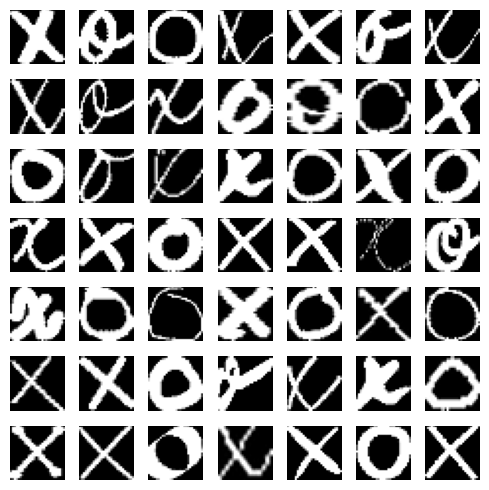

In [14]:
R, C = 7,7
fig, ax = plt.subplots(R, C, figsize=(5,5))
for label_class, plot_row in enumerate(ax):
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(1000)
        im, label = data[ix]
        print()
        plot_cell.imshow(im[0].cpu(), cmap='gray')
plt.tight_layout()

In [15]:
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
        nn.Sigmoid()
    ).to(device)

    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [16]:
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [17]:
trn_dl = DataLoader(XO('/l/disk0/ghenrique/Documents/Pytorch_book/code/all/*'), 
                    batch_size=32, 
                    drop_last=True)

In [18]:
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [19]:
model, loss_fn, optimizer = get_model()